# Capstone Project - What is in a name? (Week 2)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data - Venue names](#dataName)
* [Methodology - Venue names](#methodologyName)
* [Analysis - Venue names](#analysisName)
* [Data - Venue rating](#dataRating)
* [Methodology - Venue rating](#methodologyRating)
* [Analysis - Venue rating](#analysisRating)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction/Business Problem <a name="introduction"></a>

Names are important. More often then not, when a project for a new business ventures starts, the owner group will define a "Working Title" to refer to it, and that title may or may not end up becoming the actual name later on. But would that be wise?
What if we could have some more insight into naming conventions before choosing a definitive name for our business? Would that make any difference?
According to this article[1], "A study on behalf of the Society of Personal and Social Psychology, Inc. discovered stocks with easier to pronounce names outperformed those with names more difficult to pronounce". That is something to take in consideration. So what other insights can we take from business names?
In this article, we will explore a localized study of names used in business for several regions of Canada. We will look into the naming conventions of Food establishments, and drive our conclusions from there.

*[1] Pozin, Ilya. "Does the Name of Your Company Matter?" Accessed on July 4 2019. https://www.entrepreneur.com/article/237643*


# Data - Venue names<a name="dataName"></a>

For this article, we shall use the Foursquare API in order to get data on food buisiness names and ratings around the City of Toronto. We will use Word Clouds to visualize the most common words used in each category. We will then filter and sort the ratings to see business with high ratings, and analyzie the difference.
We will also evaluate the correlation between word count, character count, and rating of the business for a category, in order to confirm the hypothesis brought up on the article mentioned in the introductory session.


Below we will import everything we will need for this notebook

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import matplotlib.cm as cm
import matplotlib.colors as colors

import numpy as np # library to handle data in a vectorized manner

!conda install -c conda-forge wordcloud==1.4.1 --yes

from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

mpl.style.use('ggplot') # optional: for ggplot-like style


Now, using BeautifulSoup, we shall scrap the wikipedia List of Postal Codes to get a dataframe containing all of Canada postal Codes.

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'html.parser')

headers = []
data = []

table = soup.find('table')
table_body = table.find('tbody')

rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if(len(cols) > 1):
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    
    colHeaders = row.find_all('th')
    colHeaders = [ele.text.strip() for ele in colHeaders]
    if(len(colHeaders) > 1):
        headers.append([ele for ele in colHeaders if ele]) # Get rid of empty values
        
        
postalCodeList = []
BoroughList = []
NeighboorhoodList = []

for info in data:
    if((info[1] != "Not assigned") and (info[0] not in postalCodeList)):
        postalCodeList.append(info[0])
        BoroughList.append(info[1])
        neiboorhoodConcatenated = ""
        for neighboorhood in data:
            if((neighboorhood[1] != "Not assigned") and (neighboorhood[0] == info[0])):
               neiboorhoodConcatenated = ((neiboorhoodConcatenated + ", " + 
                                          (neighboorhood[2] if (neighboorhood[2] != "Not assigned") else neighboorhood[1])
                                          )if neiboorhoodConcatenated != "" else (
                                          (neighboorhood[2] if (neighboorhood[2] != "Not assigned") else neighboorhood[1])
                                          ))
        NeighboorhoodList.append(neiboorhoodConcatenated)
        
dataList=[postalCodeList, BoroughList, NeighboorhoodList]

dictionary = dict(zip(headers[0], dataList))

df = pd.DataFrame.from_dict(dictionary)

df.columns = ["PostalCode", "Borough", "Neighborhood"]


In [4]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


With the Postal Code data obtained, we now create a list of latitude and longitude data related to the postal codes

In [7]:
!wget -q -O geospatialData.csv http://cocl.us/Geospatial_data
print('Data downloaded!')
filename='geospatialData.csv'

df_geospatial = pd.read_csv(filename)

Latitude_list = []
Longitude_list = []

for index, row in df.iterrows():
    postal_code = row["PostalCode"]
    
    Latitude_list.append(df_geospatial.loc[df_geospatial["Postal Code"] == postal_code].Latitude.item())
    Longitude_list.append(df_geospatial.loc[df_geospatial["Postal Code"] == postal_code].Longitude.item())

df["Latitude"] = Latitude_list
df["Longitude"] = Longitude_list

df.head()

Data downloaded!


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


Now that we have enough neighborhood locations in canada, we can use the foursquare API to gather venues close to the provided location points. We will then create an array with all venues obtained. We shall append new data to the array using list(set(newArray + oldArray)) so as to avoid duplicated venues being inserted into our array.

In [8]:
CLIENT_ID = 'xxxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxxxx' # your Foursquare Secret

In [9]:
# function to get the location
def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=50):
    # Getting from last month 
    version = '20190607'
    # URL with specifications     
    url = 'https://api.foursquare.com/v2/search/recommendations?client_id={}&client_secret={}&v={}&ll={},{}&intent={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        # Try to perform the request. If a status such as 403 is returned, raise the exception and print the error.         
        results = requests.get(url)
        results.raise_for_status()
        
        # Turn result into JSON. Sometimes, an address will not return any venues, and in those situations the result object will not come.
        # in order to avoid errors, we first check if the results object is present.
        resultJSON = results.json()["response"]["group"]["results"] if ('results'in results.json()["response"]["group"]) else False    
        
        # Define list of venues available.
        # If rating object is not present, fill the position with "N/A" instead
        venues = ([(item['venue']['id'],
                   item['venue']['name']) for item in resultJSON] if (resultJSON != False) else [])
    except requests.exceptions.HTTPError as err:
        venues = []
    return venues

all_venues= []

# DF in this case is a collection containing the model code, latitude, and longitude of all neighboorhoods in canada.
for index, location in df.iterrows():
        
    venues = get_venues_near_location(location["Latitude"], location["Longitude"], "food", CLIENT_ID, CLIENT_SECRET, radius=350, limit=100)
    all_venues = list(set(all_venues + venues))

all_venues[0:5]


[('5462ac56498e128ccafe8fea', 'Pizzeria Libretto'),
 ('5ba55b9ae0c0c9002c29d056', 'EAT BKK Thai Kitchen'),
 ('54835826498ee8517125b280', 'Veghed'),
 ('4d75709afc766a31c3378e1a', 'Aria Ristorante'),
 ('4ae0cf40f964a520bc8221e3', "Jack Astor's Bar & Grill")]

# Methodology - Venue names  <a name="methodologyName"></a>

For this first phase, we will only need the ID and name of the venues we have acquired. We will concatenate the names of all venues into a single, separating them with a blank space, and then feed that string into the WordCloud framework where we will be able to visualize the most common words used on food venue names.

In [16]:
df_av = pd.DataFrame(all_venues)

df_av.columns = ["id","name"]
df_av.head()

,id,name
0,5462ac56498e128ccafe8fea,Pizzeria Libretto
1,5ba55b9ae0c0c9002c29d056,EAT BKK Thai Kitchen
2,54835826498ee8517125b280,Veghed
3,4d75709afc766a31c3378e1a,Aria Ristorante
4,4ae0cf40f964a520bc8221e3,Jack Astor's Bar & Grill


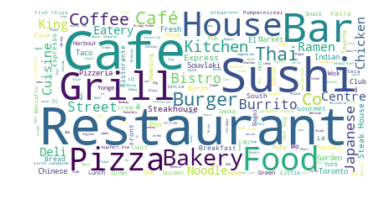

In [28]:
#### Generating the wordCloud

### Concatenating all names into one big array

venue_names = ""

# Remove duplicates by joining them together
df_av_grouped = df_av.groupby(["name"]).sum()
df_av_grouped.reset_index(inplace=True)


for index, venue in df_av_grouped.iterrows():
    venue_names = venue_names + (" " if (venue_names != "") else "") + venue["name"]
    
venue_wordcloud = WordCloud(
    background_color='white',
    max_words=2000,
)

# generate the word cloud
venue_wordcloud.generate(venue_names)

plt.imshow(venue_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Analysis - Venue names <a name="analysisName"></a>

As we can see in the Wordcloud above, a common practice among food venue names seem to be labeling them according to their business specification. Interestingly, we can also see that the therm "Cafe" is more widely used then "Coffe" for what presumably must be cafeteria venues. Finally, it seems that using the word "Restaurant" in the establishment name is a very common practice for a lot of venues.

# Data - Venue ratings  <a name="dataRating"></a>

Now that we have information on venue names, we need to gather data on their ratings to be able to make further inferences. This can be done by using the "details" endpoint from foursquare API. Please note that the details endpoint is a premium endpoint, and therefore, only a limited number of API calls can be performed. For that reason, we will take a random sample of our data to accomodate the number of premium calls we can make to foursquare.

Furthermore, not all venues will have rating information. In the event no rating information is returned, we will set the datapoint as "N/A", and will later drop the datapoint from our study dataFrame.

In [29]:
def get_venue_rating(client_id, client_secret, venue_id):
    # Getting from last month 
    version = '20190607'
    # URL with specifications     
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
        venue_id,client_id,client_secret,version)
    try:
        # Try to perform the request. If a status such as 403 is returned, raise the exception and print the error.         
        results = requests.get(url)
        results.raise_for_status()
        
        # Turn result into JSON. Sometimes, an address will not return any venues, and in those situations the result object will not come.
        # in order to avoid errors, we first check if the results object is present.
        resultJSON = results.json()["response"]["venue"]   
        
        # Define list of venues available.
        # If rating object is not present, fill the position with "N/A" instead
        rating =(resultJSON['rating'] if ('rating' in resultJSON) else "N/A")
    except requests.exceptions.HTTPError as err:
        print (err)
        rating = "N/A"
    return rating

In [73]:
#Gathering ratings

#We will have to cut our list by half, as FourSquare API only allows for 500 premium calls per day
msk = np.random.rand(len(df_av)) < 0.5
df_av_sample = df_av[msk]

rating_list = []

for index, venue in df_av_sample.iterrows():
    rating_list.append(get_venue_rating(CLIENT_ID, CLIENT_SECRET, venue["id"]))

rating_list[0:5]

[8.6, 8.1, 6.9, 7.6, 7.2]

In [72]:
pd.options.mode.chained_assignment = None  # default='warn'

df_av_sample["rating"] = rating_list

In [54]:
df_av_sample = df_av_sample[df_av_sample.rating != "N/A"]

df_av_sample.rating.astype("float")

df_av_sample.head()

,id,name,rating
0,5462ac56498e128ccafe8fea,Pizzeria Libretto,8.6
2,54835826498ee8517125b280,Veghed,8.1
3,4d75709afc766a31c3378e1a,Aria Ristorante,6.9
4,4ae0cf40f964a520bc8221e3,Jack Astor's Bar & Grill,7.6
7,4bc10b17461576b00f537b32,Detroit Eatery,7.2


Now that we have the rating information, we will generate the other 2 columns that we need for this study: The number of characters present in the venue name (nameLen), and number of words used in the name (wordCount). We will then append this information in our dataframe.

In [58]:
nameLenList = []
wordCountList = []


for index, venue in df_av_sample.iterrows():
    nameLenList.append(len(venue["name"]))
    wordCountList.append((len(venue["name"].split())))

df_av_sample["charLen"] = nameLenList
df_av_sample["wordCount"] = wordCountList
df_av_sample.head()

,id,name,rating,charLen,wordCount
0,5462ac56498e128ccafe8fea,Pizzeria Libretto,8.6,17,2
2,54835826498ee8517125b280,Veghed,8.1,6,1
3,4d75709afc766a31c3378e1a,Aria Ristorante,6.9,15,2
4,4ae0cf40f964a520bc8221e3,Jack Astor's Bar & Grill,7.6,24,5
7,4bc10b17461576b00f537b32,Detroit Eatery,7.2,14,2


# Methodology - Venue ratings  <a name="methodologyRating"></a>

To evaluate the impact that length and wordCount over buisiness ratings, we shall use linear regression to figure out the correlation between those values. We will evaluate the value of the peason correlation, as well as plot the linear regression graphs that will show us how the data points interact with one another. Finally, we will create a data set containing only business whoose ratings score higher then 8.0, and create a wordCloud using the same strategy we have used previously in this notebook.

(0, 9.41981914317061)

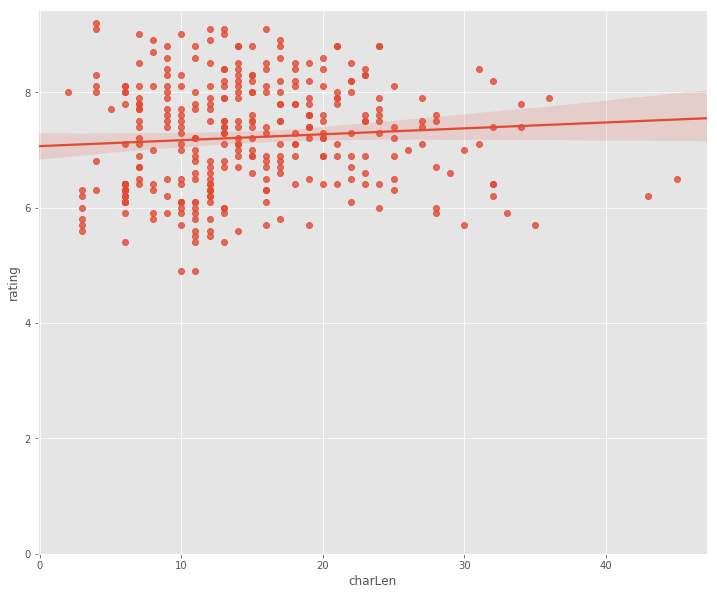

In [66]:
# import the visualization package: seaborn
import seaborn as sns
%matplotlib inline 

width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x="charLen", y="rating", data=df_av_sample)
plt.ylim(0,)

In [79]:
import scipy.stats as stats
(pearson_coef, p_value) = stats.pearsonr(df_av_sample["charLen"], df_av_sample["rating"])
print("pearson_coef: {}".format(pearson_coef))
print("p_value: {}".format(p_value))

pearson_coef: 0.08086447877649267
p_value: 0.14028571272180157


(0, 9.41981914317061)

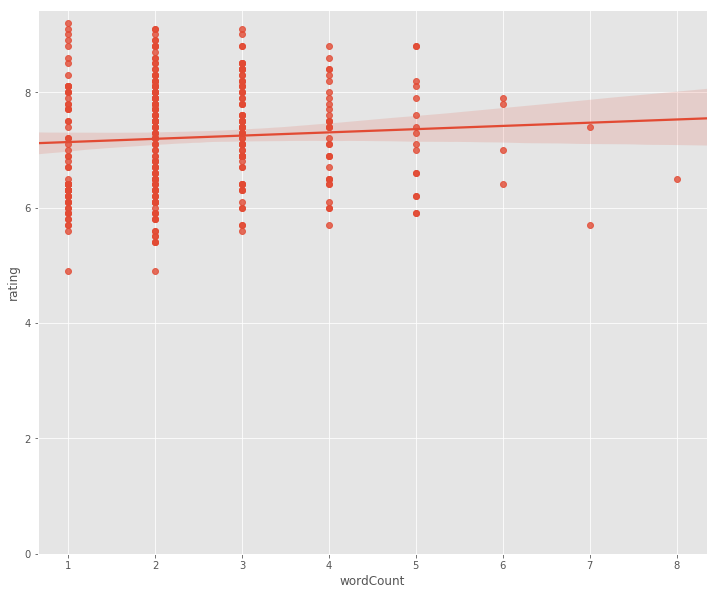

In [65]:
plt.figure(figsize=(width, height))
sns.regplot(x="wordCount", y="rating", data=df_av_sample)
plt.ylim(0,)

In [80]:
(pearson_coef, p_value) = stats.pearsonr(df_av_sample["wordCount"], df_av_sample["rating"])
print("pearson_coef: {}".format(pearson_coef))
print("p_value: {}".format(p_value))

pearson_coef: 0.07304401465932847
p_value: 0.1829578081825337


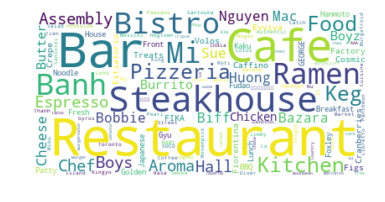

In [71]:
#### Generating the wordCloud

### Concatenating all names into one big array

high_rate_venue_names = ""

df_av_sample_high_rating = df_av_sample[df_av_sample["rating"] > 8.0]

# Remove duplicates by joining them together
df_av_sample_grouped = df_av_sample_high_rating.groupby(["name"]).sum()
df_av_sample_grouped.reset_index(inplace=True)


for index, venue in df_av_sample_grouped.iterrows():
    high_rate_venue_names = high_rate_venue_names + (" " if (venue_names != "") else "") + venue["name"]
    
high_rate_venue_wordcloud = WordCloud (
    background_color='white',
    max_words=2000,
)

# generate the word cloud
high_rate_venue_wordcloud.generate(high_rate_venue_names)

plt.imshow(high_rate_venue_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Analysis - Venue ratings  <a name="analysisRating"></a>

From what we can see from our data, the correlation between rating and name length is very small, but seem to be positive for the data attributes. We can also see that most business don't tend to surpass 30 characters for their name lengths. Finally, the wordcloud suggests similar strategies that we have foudn previously - labeling your business according to your specialization, and appending "Restaurant" to it's name, seem to be very common strategies. 

# Results and Discussion <a name="results"></a>

Based on the data gathered, we can say confidently that labeling your establishment with it's main activity, particularly using the world "Restaurant", is a popular choice among food-venue owners. Moreover, the length of the name doesn't have much correlation with it's success, however it should be noted that names with more then 30 characters are in fact more rare in their occurrence and, as such, could be an interesting niche to be explored. The sample data utilized for this study was not big enough to provide a satisfactory conclusion on the subject, given the limitations provided. However, it was enough to give a preliminary idea of the subject, and allow further studies to be performed.

For further studies, other research may use this notebook as basis to analyze this phenomena using a bigger dataset, and hopefully arrive at more meaningful conclusions. Moreover, using this data, it may be possible to use machine learning algorithms such as k-means clustering to create a name generator based on the Venues here studied, which could help business owners to have more options to select from when deciding in the name of their business.


# Conclusion <a name="conclusion"></a>

In this study, we've analysed the relationship between the name of a food venue and their rating using the platform foursquare. We've also analyzed the most common names used by business ventures, which should allow new business entrepreneurs to select their names more wisely in the future.